In [1]:
include("../code/julia/ha-trade-environment.jl")
include("../code/julia/ha-trade-solution.jl")
include("../code/julia/ha-trade-helper-functions.jl")
include("../code/julia/static-trade-environment.jl")

using FiniteDifferences
using Plots
using CSV
using DataFrames

In [14]:
Ncntry = 2

dtest = 1.75
d = dtest.*ones(Ncntry,Ncntry)
d[diagind(d)] .= 1.0

mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, Nshocks = 5, 
γ = 1.0, ϕ = 3, amax = 8.0, σ = 0.40, ρ = 0.20, σϵ = 0.25, d = d)

@unpack Na, Nshocks, Ncntry, TFP = mdl_prm

R = 1.037*ones(Ncntry);
W = 1.0*ones(Ncntry);

In [15]:
@time Y, tradeflows, A_demand, hh, dist = world_equillibrium(R, W, mdl_prm);

  0.109798 seconds (45.50 k allocations: 157.754 MiB, 4.83% gc time)


In [16]:
A_demand

2-element Vector{Float64}:
 -0.007249004866229614
 -0.007234914164187679

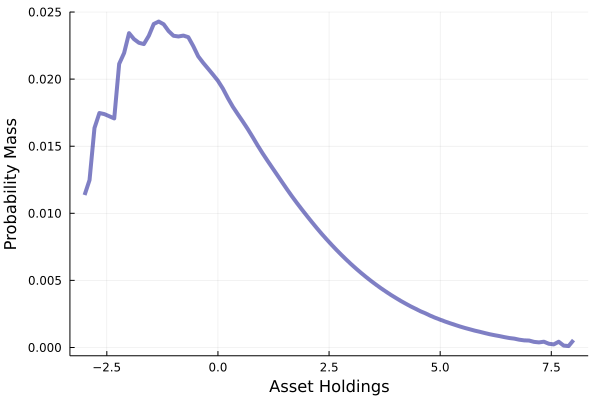

In [17]:
adist = get_distribution(dist[1].state_index, dist[1].λ);

plot(mdl_prm.agrid, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)

In [18]:
function make_Mij_Mii(∂d, R, W, home, source, model_params)

    p = make_p(∂d, W, home, source, model_params)

    hh = solve_household_problem(R, W, p, model_params, solution_method = "nl-fixedpoint", tol = 1e-10)
    #itteration is not working properly...need to fix, nlfixed point yes

    state_index = Array{Tuple{eltype(Int64), eltype(Int64)}}(undef, model_params.Na*model_params.Nshocks, 1)
    
    make_state_index!(state_index, model_params)

    pcπ_by_state , πprob_by_state, pc_by_state = get_trade(R, W, hh.asset_policy, hh.πprob, state_index, model_params)

    Mij_Mii_total = (pcπ_by_state[:,source]) ./ (pcπ_by_state[:,home])
    
    Mij_Mii_imargin = (pc_by_state[:,source]) ./ (pc_by_state[:,home])
    
    Mij_Mii_xmargin = (πprob_by_state[:,source]) ./ (πprob_by_state[:,home])

    return Mij_Mii_total, Mij_Mii_imargin, Mij_Mii_xmargin

end

function make_p(∂d, W, home, source, model_params)

    @unpack TFP, d = model_params

    p = (W ./ TFP[home] ) .* d[home, :]

    p[source] = (W ./ TFP[home] )*∂d

    return p

end

function make_dataset(∂logM_∂logd, model_params)
    
    elasticity_mat = Array{eltype(∂logM_∂logd)}(undef, model_params.Na, model_params.Nshocks)
    
    state_index = Array{Tuple{eltype(Int64), eltype(Int64)}}(undef, model_params.Na*model_params.Nshocks, 1)
    
    make_state_index!(state_index, model_params)
    
    for (foo, xxx) in enumerate(state_index)
        
        elasticity_mat[xxx[1], xxx[2]] = ∂logM_∂logd[foo]
    end
    
    return elasticity_mat
    
end

function make_dataset_dataframe(∂logM_∂logd, model_params)
    
    elasticity = Array{eltype(∂logM_∂logd)}(undef, model_params.Na*model_params.Nshocks)
    shock = Array{eltype(∂logM_∂logd)}(undef, model_params.Na*model_params.Nshocks)
    asset = Array{eltype(∂logM_∂logd)}(undef, model_params.Na*model_params.Nshocks)
    
    state_index = Array{Tuple{eltype(Int64), eltype(Int64)}}(undef, model_params.Na*model_params.Nshocks, 1)
    
    make_state_index!(state_index, model_params)
    
    for (foo, xxx) in enumerate(state_index)
        
        shock[foo] = xxx[2]
        
        asset[foo] = model_params.agrid[xxx[1]]
        
        elasticity[foo] = ∂logM_∂logd[foo]
    end
    
    df = DataFrame(asset = asset, 
               shock = shock,
               elasticity = elasticity, 
               );
    
    return df
    
end     

make_dataset_dataframe (generic function with 1 method)

In [19]:
home = 1

source = 2

h(x) = make_Mij_Mii(x[1], R[home], W[home], home, source, mdl_prm)[1]

∂M_∂d = jacobian(central_fdm(2, 1), h, [dtest])[1]

∂logM_∂logd = ∂M_∂d .* (dtest ./ h(dtest));

df = make_dataset_dataframe(∂logM_∂logd, mdl_prm)

CSV.write("elasticity_total-log.csv", df)

"elasticity_total-log.csv"

In [20]:
df = make_dataset_dataframe(h(dtest), mdl_prm)

CSV.write("trade_share-log.csv", df)

"trade_share-log.csv"

In [286]:
asset

LoadError: UndefVarError: asset not defined

In [274]:
df


,asset_index,z1,z2,z3,z4,z5
,Float64,Float64,Float64,Float64,Float64,Float64
1,-3.0,-12.107,-7.98402,-5.63196,-4.77586,-4.30798
2,-2.88889,-9.56665,-7.10815,-5.32764,-4.71709,-4.28886
3,-2.77778,-8.15662,-6.46759,-5.29195,-4.66756,-4.27068
4,-2.66667,-7.24481,-5.93212,-5.15095,-4.62537,-4.27119
5,-2.55556,-6.35594,-5.82347,-5.0122,-4.58185,-4.25346
6,-2.44444,-6.19815,-5.48732,-4.93623,-4.54735,-4.2364
7,-2.33333,-5.73117,-5.31478,-4.92491,-4.51622,-4.22015
8,-2.22222,-5.66608,-5.27255,-4.84957,-4.48462,-4.20449
9,-2.11111,-5.4581,-5.10956,-4.78261,-4.45538,-4.1889
